In [1]:
import numpy as np 
from scipy.linalg import expm 
import matplotlib.pyplot as plt 
from main.tomography import Hamiltonian_Learning, Pauli_Transfer_Matrix
from main.randomized_compiling import RandomizedCompiling
import json
from qiskit_ibm_runtime import RuntimeEncoder, RuntimeDecoder

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel='ibm_cloud', 
                                token='')
backend = service.backend('ibm_brisbane')
coupling = backend.configuration().coupling_map

qubits_layaout = [13,12,11,10,9,8,7,6,5,4,3,2,1,0,14,
                    18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,36,
                    51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,52,
                    56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,74,
                    89,88,87,86,85,84,83,82,81,80,79,78,77,76,75,90,
                    94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,112,
                    126,125,124,123,122,121,120,119,118,117,116,115,114,113] 

Setting the functions for the postprocessing of the Hamiltonian Learning protocol.

In [ ]:
# # each in 36s
# job_ids = ['d1jdt5r9fb3c73ef1r10',
#             'd1jdrcb9fb3c73ef1ot0',
#             'd1jdpjr9fb3c73ef1n1g',
#             'd1jb5lf29o4s73an1gf0',
#             'd1jpf7fa572c73956uvg',
#             'd1jpgu39fb3c73efg8qg',
#             'd1jrt8j9fb3c73efjf50',
#             'd1juu4r9fb3c73efnrog',
#             'd1k13j39fb3c73efqg2g'
#             ]

# results = [] 
# for id in job_ids: 
#     job = service.job(id) 
#     for primitive_result in job.result(): 
#         results.append( primitive_result ) 

# with open("datos_100q_RC.json", "w") as file:
#     json.dump(results, file, cls=RuntimeEncoder)

In [4]:
with open("datos_100q_RC.json", "r") as file:
    results = json.load(file, cls=RuntimeDecoder) 

results

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=900, num_bits=73>))), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=900, num_bits=73>))), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=900, num_bits=73>))), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=900, num_bits=73>))), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=900, num_bits=73>))), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=900, num_bits=73>))), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=900, num_bits=73>))), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=900, num_bits=73>))), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=900, num_bits=73>))), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=900, num_bits=73>))), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=900, num_bits=73>))), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_sho

Setting the functions for the postprocessing of the Hamiltonian Learning protocol.

In [5]:
num_qubits = 109
hs = [ 1/8 for j in range(num_qubits) ] # parameters h_j
Js = [ 1/16 for j in range(num_qubits-1) ] # Parameters J_j
hamil_learn = Hamiltonian_Learning( num_qubits )
qubits_tomo = hamil_learn.groups_qubits_tomo()

In [6]:
I = np.eye(2)
Z = np.diag([1,-1])
X = np.array([[0,1],[1,0]])
H = (1/8)*np.kron(I,Z) + (1/8)*np.kron(Z,I) + (1/16)*np.kron(X,X)
U = expm( -1j*H )

In [7]:
probs = [ prob.data.c.get_counts() for prob in results ]
n_shots = int( np.sum([ list(prob.values()) for prob in probs ]) )
n_shots

874800

In [8]:
Hs = hamil_learn.hamiltonian_from_tomo( probs, init=U ) 

In [9]:
lambdaa = hamil_learn.noise()
np.mean( lambdaa ), np.std(lambdaa)

(1.774547284885692, 0.499452141275428)

Comparison Theory vs Experiment

In [10]:
print( 'Theory' ) 
print( hs[0], hs[0], Js[0]) 
print('------------------') 
print( 'Experiment' ) 
for j in range(num_qubits-1): 
    pauli_coef_tomo = Pauli_Transfer_Matrix( Hs[j], 
                                            num_qubits=2 ) 
    # print( pauli_coef_tomo.round(3) ) 
    print( pauli_coef_tomo[0,-1],
            pauli_coef_tomo[-1,0],
            pauli_coef_tomo[1,1]) 

Theory
0.125 0.125 0.0625
------------------
Experiment
0.10082091022668607 0.13112393804618339 0.06349960772457974
0.16195958732085075 0.1227452708000469 0.0555314115258267
0.14259361531227643 0.13361265974786016 0.0347262774793098
0.12790520147875073 0.1441416924969207 0.03371893048243375
0.1324133118109299 0.13617736077512593 0.05951108445121942
0.1485273946784926 0.09826104421432005 0.06069006493574895
0.13768612222379195 0.1339570465311679 0.04476223580672149
0.11930737698826953 0.1611802556904119 0.09625225318275517
0.144079628277881 0.1354706517426185 0.09263066489596843
0.1310147712064698 0.14243826351118505 0.05540958724019073
0.14595186506264834 0.14313716484219904 0.055114322356727495
0.10812359197063223 0.11700667456952316 0.056517777411500464
0.13960296632415486 0.1499396215181063 0.05285337630853974
0.15830856405871307 0.15205022061248985 0.07064539839935957
0.1468469662567552 0.13337624363744477 0.08519841167245443
0.11359038656674222 0.13890230501472797 0.07827921805952

We create a new Json file with the postprocessed results.

In [11]:
qubits_tomo = np.array( qubits_tomo ).reshape(-1,2)

params_local = { str(j):[] for j in qubits_layaout }
errors_local = { str(j):[] for j in qubits_layaout }
params_two   = {}
errors_two   = {}

for j, (q1, q2) in enumerate(qubits_tomo):
    pauli_coef_tomo = Pauli_Transfer_Matrix( Hs[j], num_qubits=2 ) 

    params_local[str(qubits_layaout[q1])].append( pauli_coef_tomo[0,-1] )
    params_local[str(qubits_layaout[q2])].append( pauli_coef_tomo[-1,0] )
    params_two[str((qubits_layaout[q1],qubits_layaout[q2]))]= pauli_coef_tomo[1,1]
    params_two[str((qubits_layaout[q2],qubits_layaout[q1]))]= pauli_coef_tomo[1,1]

    errors_local[str(qubits_layaout[q1])].append( abs(1/8-pauli_coef_tomo[0,-1]) )
    errors_local[str(qubits_layaout[q2])].append( abs(1/8-pauli_coef_tomo[-1,0]) )
    errors_two[str((qubits_layaout[q1],qubits_layaout[q2]))]= abs(1/16-pauli_coef_tomo[1,1])
    errors_two[str((qubits_layaout[q2],qubits_layaout[q1]))]= abs(1/16-pauli_coef_tomo[1,1])

params_local = { j : np.mean(params_local[j]) for j in params_local }
errors_local = { j : np.mean(errors_local[j]) for j in errors_local }

In [12]:
params = { 'params':{'h': params_local,
                        'J': params_two },
        'error' : {'h' : errors_local,
                        'J' : errors_two}, 
        'coupling' : coupling,
        'shots'  :  n_shots, 
        'lambda' : lambdaa, 
                }

with open("params_100q_RC.json", "w") as file:
        json.dump(params, file )

In [13]:
qubit_coords = {
    # (index: (x, y)) coordinates matching the layout you uploaded
    0: (0, 0), 1: (1, 0), 2: (2, 0), 3: (3, 0), 4: (4, 0), 5: (5, 0), 6: (6, 0),
    7: (7, 0), 8: (8, 0), 9: (9, 0), 10: (10, 0), 11: (11, 0), 12: (12, 0), 13: (13, 0),
    14: (0, 1), 15: (4, 1), 16: (8, 1), 17: (12, 1),
    18: (0, 2), 19: (1, 2), 20: (2, 2), 21: (3, 2), 22: (4, 2), 23: (5, 2), 24: (6, 2),
    25: (7, 2), 26: (8, 2), 27: (9, 2), 28: (10, 2), 29: (11, 2), 30: (12, 2), 31: (13, 2),
    32: (14, 2), 33: (2, 3), 34: (6, 3), 35: (10, 3), 36: (14, 3), 37: (0, 4), 38: (1, 4),
    39: (2, 4), 40: (3, 4), 41: (4, 4), 42: (5, 4), 43: (6, 4), 44: (7, 4), 45: (8, 4),
    46: (9, 4), 47: (10, 4), 48: (11, 4), 49: (12, 4), 50: (13, 4), 51: (14, 4), 52: (0, 5),
    53: (4, 5), 54: (8, 5), 55: (12, 5), 56: (0, 6), 57: (1, 6), 58: (2, 6), 59: (3, 6),
    60: (4, 6), 61: (5, 6), 62: (6, 6), 63: (7, 6), 64: (8, 6), 65: (9, 6), 66: (10, 6),
    67: (11, 6), 68: (12, 6), 69: (13, 6), 70: (14, 6), 71: (2, 7), 72: (6, 7), 73: (10, 7),
    74: (14, 7), 75: (0, 8), 76: (1, 8), 77: (2, 8), 78: (3, 8), 79: (4, 8), 80: (5, 8),
    81: (6, 8), 82: (7, 8), 83: (8, 8), 84: (9, 8), 85: (10, 8), 86: (11, 8), 87: (12, 8),
    88: (13, 8), 89: (14, 8), 90: (0, 9), 91: (4, 9), 92: (8, 9), 93: (12, 9), 94: (0, 10),
    95: (1, 10), 96: (2, 10), 97: (3, 10), 98: (4, 10), 99: (5, 10), 100: (6, 10), 101: (7, 10),
    102: (8, 10), 103: (9, 10), 104: (10, 10), 105: (11, 10), 106: (12, 10), 107: (13, 10),
    108: (14, 10), 109: (2, 11), 110: (6, 11), 111: (10, 11), 112: (14, 11), 113: (1, 12),
    114: (2, 12), 115: (3, 12), 116: (4, 12), 117: (5, 12), 118: (6, 12), 119: (7, 12),
    120: (8, 12), 121: (9, 12), 122: (10, 12), 123: (11, 12), 124: (12, 12), 125: (13, 12),
    126: (14, 12),
}

We create a color plot to display the results.

In [ ]:
import matplotlib.colors as colors

def plot_map(coords, edges, error_local, error_two, 
                name='', max_err_local=None, max_err_two=None):
    
    
    fig, ax = plt.subplots(figsize=(14, 10))

    ####
    vals_local = list(error_local.values())
    if max_err_local is None:
        max_err_local = max(vals_local)
    norm_local = colors.LogNorm( min(vals_local), max_err_local )
    cmap_local = plt.cm.viridis_r #inferno_r 

    ####
    vals_two = list(error_two.values())
    if max_err_two is None:
        max_err_two = max(vals_two)
    norm_two = colors.LogNorm(min(vals_two), max_err_two)
    cmap_two = plt.cm.plasma_r #magma_r 

    for qi, qj in edges:
        x1, y1 = coords[qi]; x2, y2 = coords[qj]
        errorij = error_two.get(str((qi, qj)),None)
        if errorij is None:
            ax.plot([x1, x2], [-y1, -y2],
                color='black', lw=9.5, zorder=1)
            ax.plot([x1, x2], [-y1, -y2],
                color='white', lw=8, zorder=1)
        else:
            if errorij > max_err_two :
                ax.plot([x1, x2], [-y1, -y2],
                color='black', lw=8, zorder=1)
            else:
                ax.plot([x1, x2], [-y1, -y2],
                    c=cmap_two(norm_two(errorij)), lw=8, zorder=1)

    for q, (x, y) in coords.items(): 

        errorq = error_local.get(str(q),None)
        if errorq is None:
            ax.scatter( x, -y, s=2*500, color='white', 
                    edgecolors='black', zorder=2 ) 
            ax.text( x, -y, str(q), ha='center', va='center', 
                color='black', fontsize=12, zorder=3) 
        else:
            if errorq > max_err_local :
                ax.scatter( x, -y, s=2*500, color='black', 
                        edgecolors='white', zorder=2 ) 
            else:
                ax.scatter( x, -y, s=2*500, color=cmap_local(norm_local(errorq)), 
                            edgecolors='white', zorder=2 ) 
            ax.text( x, -y, str(q), ha='center', va='center', 
                    color='white', fontsize=12, zorder=3) 

    sm_two = plt.cm.ScalarMappable(cmap=cmap_two, norm=norm_two)
    cbar_two = plt.colorbar(sm_two, ax=ax, shrink=0.75, pad=-0.05 ) 

    sm_local = plt.cm.ScalarMappable(cmap=cmap_local, norm=norm_local)
    cbar_local = plt.colorbar(sm_local, ax=ax, shrink=0.75, pad=0.01 ) 

    cbar_local.ax.set_title(r'$|h-\hat{h}_i|$')
    cbar_two.ax.set_title(r'$|J-\hat{J}_i|$')

    cbar_local.ax.tick_params(labelsize=14) 
    cbar_two.ax.tick_params(labelsize=14) 

    ax.set_aspect('equal') 
    ax.axis('off') 
    ax.set_title(name, fontsize=16) 
    plt.tight_layout() 
    # plt.show() 

    return fig 

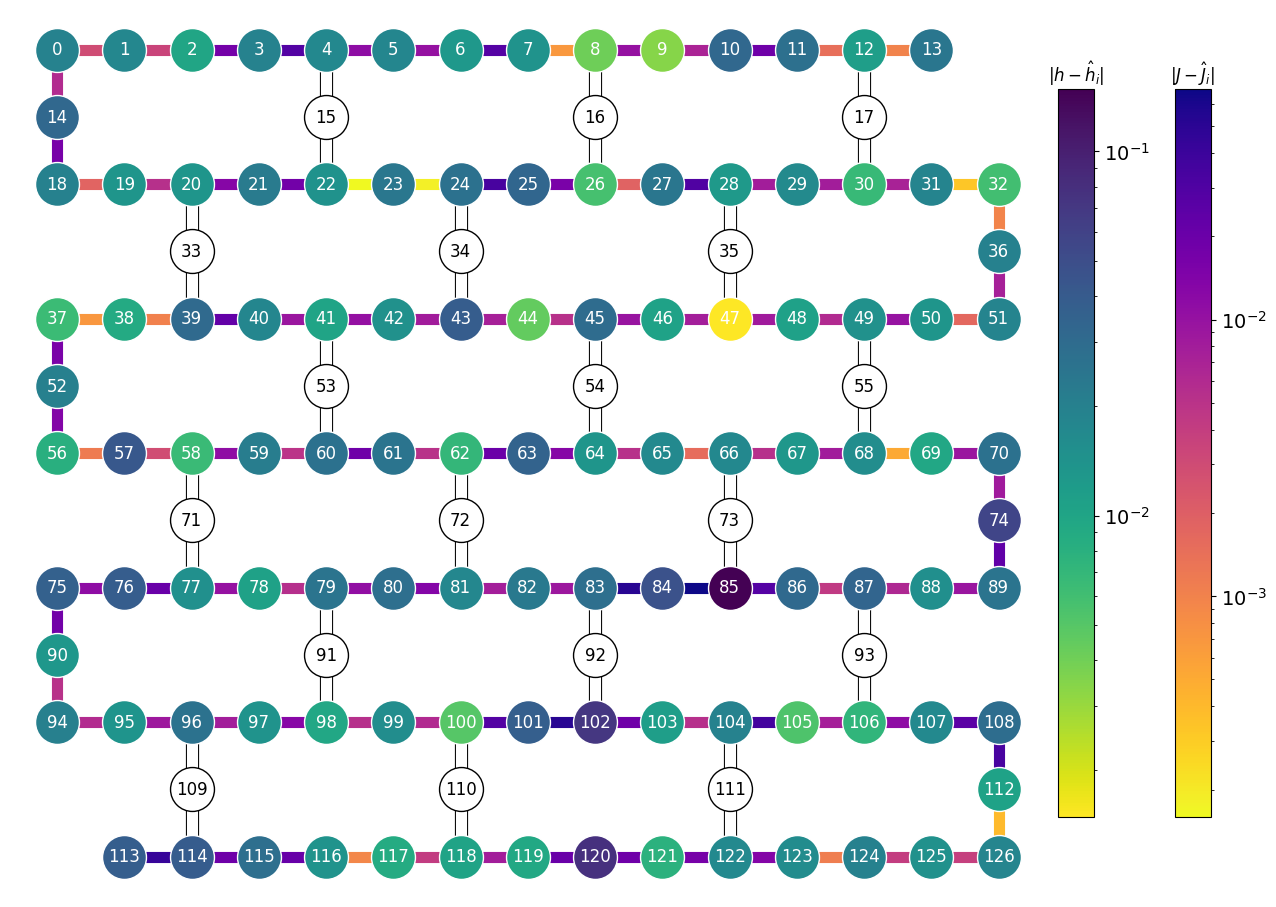

In [15]:
# from main.visualization import plot_map 
fig = plot_map(qubit_coords, coupling, errors_local, errors_two ) 
fig.savefig('color_plot_109q.pdf', bbox_inches='tight') 